## **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,Model
import PIL
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import PIL
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

2024-05-07 16:13:17.384058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 16:13:17.384141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 16:13:17.500471: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Dataset Sample**

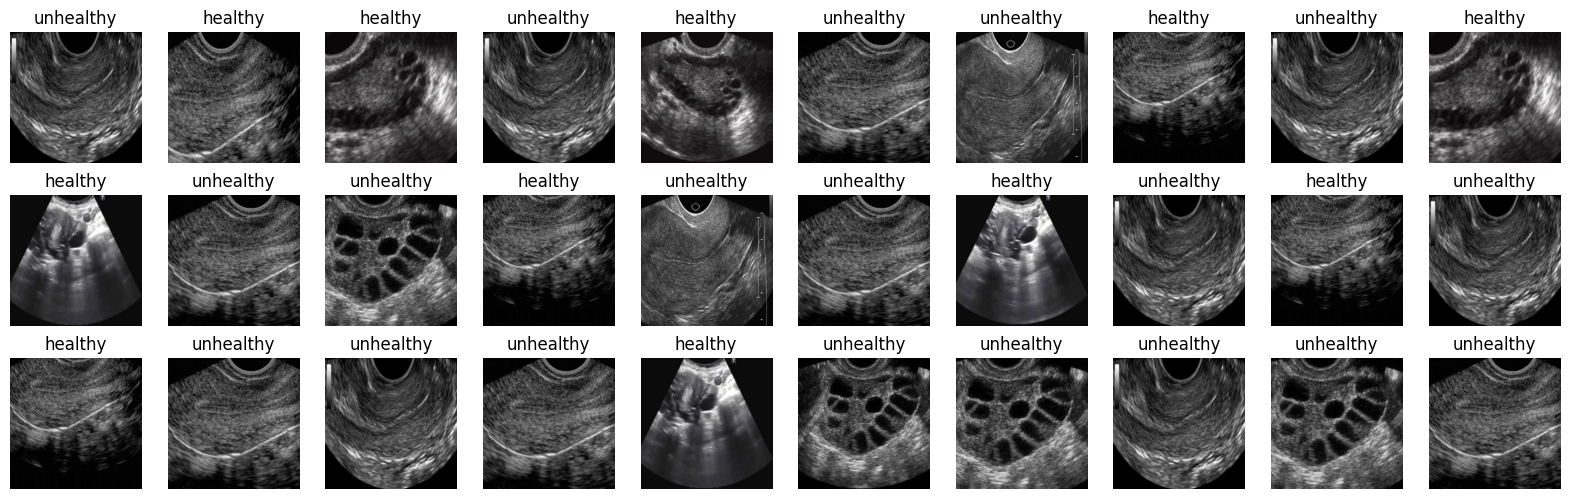

In [2]:
class1_dir = "/kaggle/input/dataset1/traindata/healthy"
class2_dir = "/kaggle/input/dataset1/traindata/unhealthy"
num_images_per_class = 6
h=3
w=10
# Load images from directories
class1_images = [os.path.join(class1_dir, filename) for filename in os.listdir(class1_dir)[:num_images_per_class]]
class2_images = [os.path.join(class2_dir, filename) for filename in os.listdir(class2_dir)[:num_images_per_class]]
all_images = class1_images + class2_images

def load_img(filename):
    return np.array(PIL.Image.open(filename).resize((300, 300)))

fig, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))

for i in range(h):
    for j in range(w):
        ax = axes_list[i, j]
        ax.axis('off')
        img = np.random.choice(all_images)
        ax.imshow(load_img(img))      
        if img in class1_images:
            ax.set_title("healthy")
        else:
            ax.set_title("unhealthy")

plt.show()

## **Dataset classes**

In [3]:
dataset_path = os.listdir("/kaggle/input/dataset1/traindata")
print (dataset_path)
print("Types of classes labels found: ", len(dataset_path))

['healthy', 'unhealthy']
Types of classes labels found:  2


## **Labels mapping**

In [4]:
class_labels = []

for item in dataset_path:
 # Get all the file names
 all_classes = os.listdir('/kaggle/input/dataset1/traindata' + '/' +item)
 #print(all_classes)

 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))
    #print(class_labels[:5])

In [5]:
# Build a dataframe        
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())
print(df.tail())

    Labels                               image
0  healthy  dataset_path/healthy/image1465.jpg
1  healthy  dataset_path/healthy/image3573.jpg
2  healthy  dataset_path/healthy/99image40.jpg
3  healthy  dataset_path/healthy/image2915.jpg
4  healthy  dataset_path/healthy/image2371.jpg
         Labels                                  image
3184  unhealthy   dataset_path/unhealthy/image3681.jpg
3185  unhealthy   dataset_path/unhealthy/image1130.jpg
3186  unhealthy  dataset_path/unhealthy/281image17.jpg
3187  unhealthy   dataset_path/unhealthy/image0055.jpg
3188  unhealthy   dataset_path/unhealthy/image0107.jpg


In [6]:
import cv2
path = '/kaggle/input/dataset1/traindata/'
dataset_path = os.listdir('/kaggle/input/dataset1/traindata')

im_size = 224

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)


In [7]:
#This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. 

images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(3189, 224, 224, 3)

In [8]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

['healthy' 'healthy' 'healthy' ... 'unhealthy' 'unhealthy' 'unhealthy']
[0 0 0 ... 1 1 1]


In [9]:
y=y.reshape(-1,1)
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y) #.toarray()
print(Y[:5])
print(Y[35:])



[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## **Dataset split into train,val and test**

In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers


images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.3, random_state=42)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(2232, 224, 224, 3)
(2232, 2)
(957, 224, 224, 3)
(957, 2)


## **Training Model**

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 2
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# Using model without transfer learning

outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)



In [12]:
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

model.summary()

hist = model.fit(train_x,train_y, epochs=15, verbose=2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 2)              │     4,052,133 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/15


I0000 00:00:1715098540.536410     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715098540.644213     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 - 168s - 2s/step - accuracy: 0.6290 - loss: 1.9178
Epoch 2/15


W0000 00:00:1715098611.096071     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 - 17s - 240ms/step - accuracy: 0.6443 - loss: 1.2103
Epoch 3/15
70/70 - 10s - 149ms/step - accuracy: 0.6703 - loss: 0.7438
Epoch 4/15
70/70 - 9s - 130ms/step - accuracy: 0.7007 - loss: 0.6090
Epoch 5/15
70/70 - 9s - 127ms/step - accuracy: 0.7039 - loss: 0.6677
Epoch 6/15
70/70 - 9s - 126ms/step - accuracy: 0.6877 - loss: 0.5804
Epoch 7/15
70/70 - 9s - 125ms/step - accuracy: 0.7491 - loss: 0.4915
Epoch 8/15
70/70 - 9s - 125ms/step - accuracy: 0.7863 - loss: 0.4381
Epoch 9/15
70/70 - 9s - 125ms/step - accuracy: 0.8289 - loss: 0.3840
Epoch 10/15
70/70 - 9s - 126ms/step - accuracy: 0.8642 - loss: 0.3339
Epoch 11/15
70/70 - 9s - 126ms/step - accuracy: 0.9091 - loss: 0.2369
Epoch 12/15
70/70 - 9s - 128ms/step - accuracy: 0.8302 - loss: 0.3891
Epoch 13/15
70/70 - 9s - 127ms/step - accuracy: 0.8548 - loss: 0.3589
Epoch 14/15
70/70 - 9s - 127ms/step - accuracy: 0.9001 - loss: 0.2472
Epoch 15/15
70/70 - 9s - 126ms/step - accuracy: 0.9198 - loss: 0.2271


## **Loss and Accuracy of train and validation dataset**

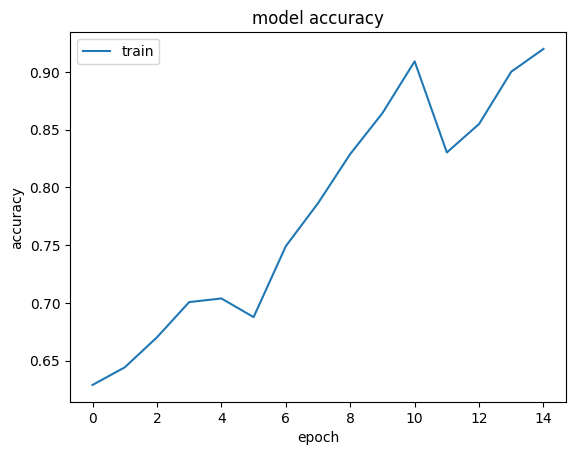

In [13]:
plt.plot(hist.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

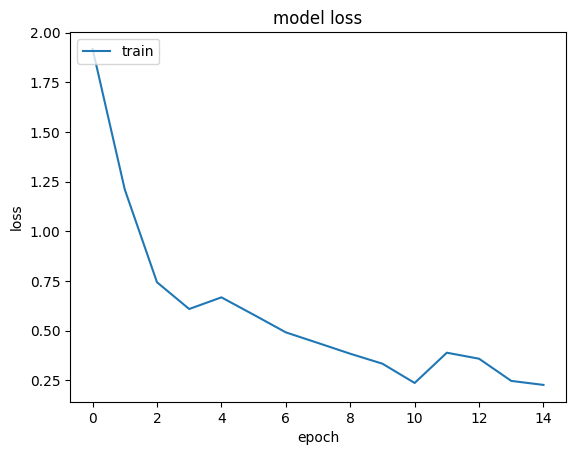

In [14]:
plt.plot(hist.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [15]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

 3/30 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6337 - loss: 0.8921

W0000 00:00:1715098805.882881     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.6326 - loss: 1.0912
Loss = 1.1390033960342407
Test Accuracy = 0.638453483581543


W0000 00:00:1715098816.084397     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## **ROC Curve**

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


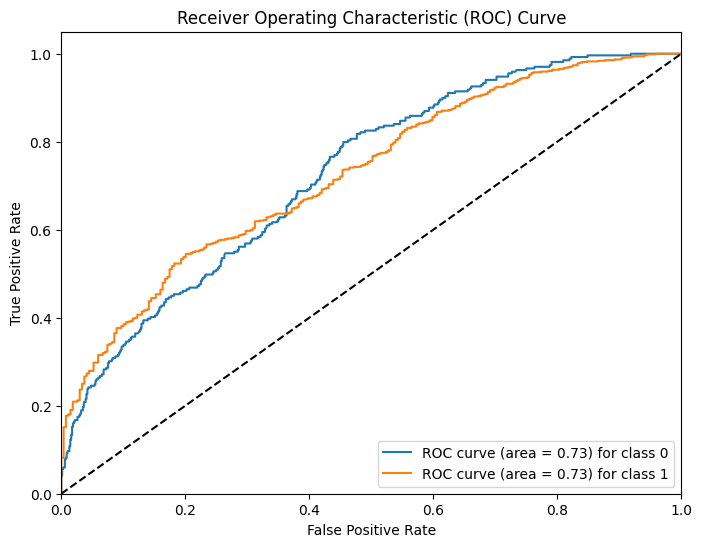

In [18]:
from sklearn.metrics import roc_curve, auc

# Assuming model.predict_proba(test_x) returns the predicted probabilities
pred_probs = model.predict(test_x)

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):  # Replace num_classes with the number of classes
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(2):  # Replace num_classes with the number of classes
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## **Test Image**

In [21]:
img_path = '/kaggle/input/dataset1/traindata/unhealthy/100image94.jpg'

Input image shape: (1, 224, 224, 3)


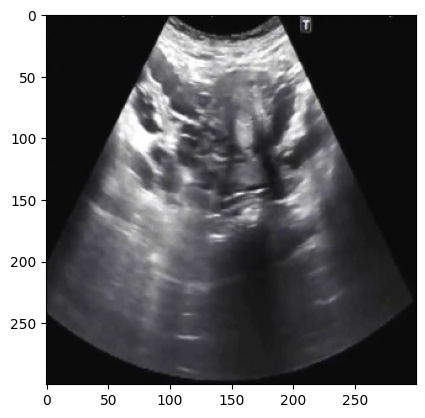

In [22]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)

## **Image Classification** 

In [23]:
preds=model.predict(x)
max_pred = np.max(preds)

print("Maximum prediction value:", max_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Maximum prediction value: 0.66510844


## **Using GRAD-CAM for visualization model attention**

In [24]:
# Load EfficientNetB0 model with imagenet weights
model = EfficientNetB0(weights='imagenet', include_top=True)

# Define the last convolutional layer name
last_conv_layer_name = "top_conv"

# Define the image size
img_size = (224, 224)

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n03534580', 'hoopskirt', 9.224565)]


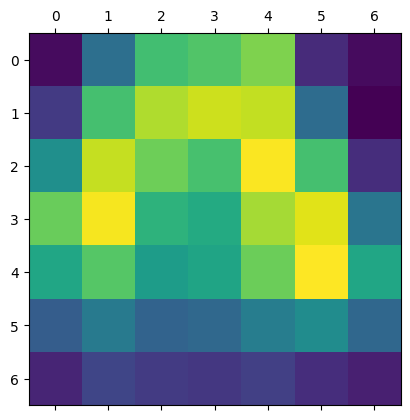

In [25]:
# Prepare image
model_builder = keras.applications.EfficientNetB0
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation =None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [33]:
from PIL import Image
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

    save_and_display_gradcam(img_path, heatmap)

## **Attention Map**

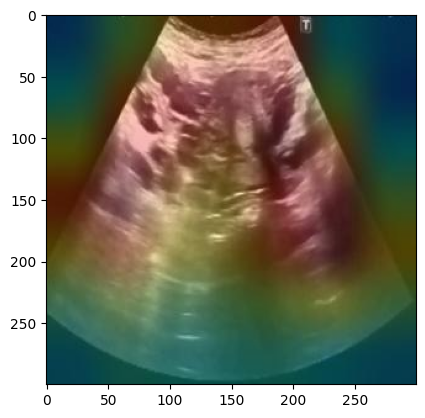

In [34]:
my_image = imread("/kaggle/working/cam.jpg")
imshow(my_image)